# 室内场景三维重建 - 课程大作业

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# 导入必要的库
import cv2
import numpy as np
from pathlib import Path
from process import *
import process.feature_extraction as fe
import process.feature_matching as fm
from util import *

In [3]:
# 初始化数据保存路径
data_path = Path.cwd() / "data"

## Step0: 导入图像及相机参数

In [4]:
# 是否重新生成数据
regenerate = False
cache_key = "images_and_intrinsics"

images, camera_intrinsic = cache_wrapper(cache_key, regenerate, load_images_and_camera_intrinsic)(data_path)

### 测试：展示图像和相机参数

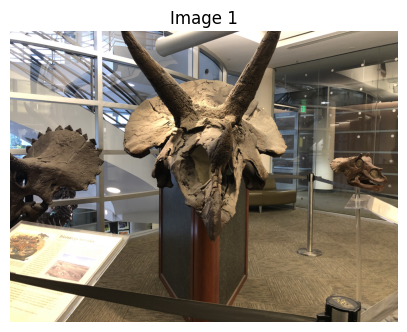

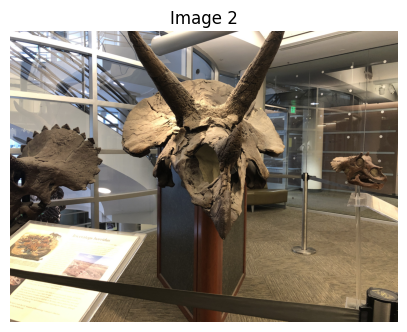

相机内参矩阵:
[[3.2256e+03 0.0000e+00 2.0160e+03]
 [0.0000e+00 3.2256e+03 1.5120e+03]
 [0.0000e+00 0.0000e+00 1.0000e+00]]


In [5]:
# 展示读取的图像
for i, img in enumerate(images[:2]):
    plt_show(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), f"Image {i+1}")

# 展示相机内参
print("相机内参矩阵:")
print(camera_intrinsic)

## Step1: 图像特征提取 (SIFT)

In [6]:
regenerate = False
data_cache_key = "sift"

# 运行SIFT特征提取
features = cache_wrapper(
    data_cache_key,
    regenerate,
    extract_features,
    fe.after_load,
)(images)

### 测试：展示图像特征点

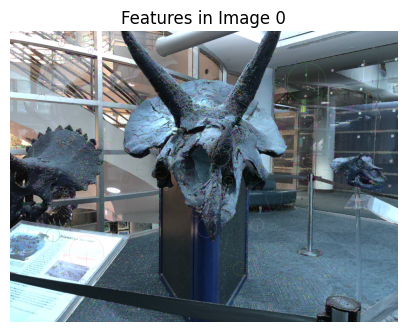

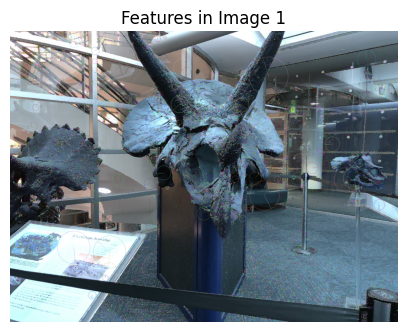

In [7]:
# 展示特征点
for i, img in enumerate(images[:2]):
    img_with_features = cv2.drawKeypoints(
        img, features[i][0], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    plt_show(img_with_features, f"Features in Image {i}")

## Step2: 图像特征匹配

In [8]:
# 是否要重新生成该部分数据
regenerate = False
data_cache_key = "matches"

# 运行特征匹配
all_matches = cache_wrapper(data_cache_key, regenerate, match_all_paires, fm.after_load)(features)

### 测试：展示匹配结果

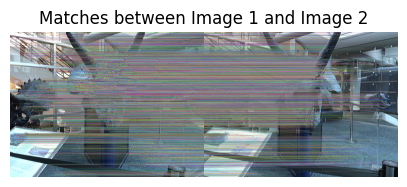

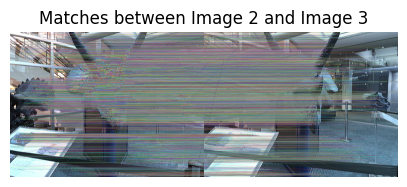

In [9]:
for i, (img1, img2) in enumerate(zip(images[:2], images[1:3])):
    img_matches = visualize_matches(
        img1, img2, all_matches[(i, i + 1)], features[i], features[i + 1]
    )
    plt_show(img_matches, f"Matches between Image {i+1} and Image {i+2}")

## Step3: 场景初始化 (对极几何)

In [ ]:
# 是否要重新生成该部分数据
regenerate = True
data_cache_key = "init_recon"

# 初始化重建
points3D, camera_pose, recon_valid_points, points1, points2 = cache_wrapper(data_cache_key, regenerate, init_recon)(
    features[0], features[1], all_matches[(0, 1)], camera_intrinsic
)

基础矩阵:
[[ 2.57807031e-08  8.97757455e-07  7.55350134e-04]
 [-6.22895309e-07  2.60931330e-08  2.29454707e-02]
 [-1.24150481e-03 -2.35298552e-02  1.00000000e+00]]

本质矩阵:
[[  0.26823521   9.34071328   6.98256375]
 [ -6.48091135   0.27148588  70.08959974]
 [ -6.87487809 -69.93269613   0.13858746]]

旋转矩阵:
[[ 0.99920312  0.00116851 -0.03989687]
 [-0.00120952  0.99999876 -0.00100383]
 [ 0.03989565  0.00105129  0.9992033 ]]

平移向量:
[[ 0.98642448]
 [-0.09853071]
 [ 0.13137143]]

数据已保存到缓存: init_recon


### 测试：展示初始化结果

In [11]:
# 展示相机位置和点云
# visualize_camera_pose_and_pcd([camera_pose], points3D)

## Step4: 场景重建 (PnP)

In [ ]:
# 是否要重新生成该部分数据
regenerate = True
data_cache_key = "pnp"

# 执行PnP算法来估计相机姿态
camera_poses, points2Ds, point3Ds = cache_wrapper(
    data_cache_key, regenerate, perform_PnP_on_all
)(points3D, features, all_matches, camera_intrinsic, recon_valid_points, camera_pose)
camera_poses.insert(0, (np.eye(3), np.zeros((3, 1))))
points2Ds.insert(0, points1)
points2Ds.insert(1, points2)
point3Ds.insert(0, points3D)
point3Ds.insert(1, points3D)

### 测试：展示重建结果

In [ ]:
# 展示相机位置和点云
print(f"相机位置数量: {len(camera_poses)}")
visualize_camera_pose_and_pcd(camera_poses, points3D)

相机位置数量: 61


: 

## Step5: 场景优化 (Bundle Adjustment)

In [ ]:
# 是否要重新生成该部分数据
regenerate = False
data_cache_key = "ba"

# 执行BA算法来优化相机姿态和点云
camera_poses, points3D = cache_wrapper(data_cache_key, regenerate, perform_BA)(
    points2Ds, point3Ds, camera_poses, camera_intrinsic
)